# How convolutional networks see the world

In this notebook we visualize the patterns learned by different layers of a convolutional neural network (cnn) to see how cnns understand the images fed to them. Each convolution layer has several filters (neurons) that each learn a certain template. For example, a filter can be used to detect simple templates such as a line or curve or a more complex feature such as an eye. An image containing a similar template when filtered through these filters will maximize the output of that filter. Filters are also referred to as kernels. Some example filters can be seen [here](https://en.wikipedia.org/wiki/Kernel_(image_processing)).

We use the cifar-10 image dataset for this exercise. Details of the cifar-10 dataset can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html). 

**Note:** To better understand this exercise read Chapter 5 of Francois Chollet's Deep Learning with Python book. It is available online through the RHUL library [here](https://www.safaribooksonline.com/library/view/Deep+Learning+with+Python/9781617294433/kindle_split_015.html#ch05).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
# If running on lab machine execute this cell
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras import models 
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

In [4]:
# Load cifar-10 image dataset. Details of the CIFAR-10 dataset can be found 
(cx_train, cy_train),(cx_test, cy_test) = cifar10.load_data()
print(cx_train.shape)
print(cy_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [5]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18)):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = images_to_plot.shape[0]
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()

    for i in range(n_images):
        ax[i].imshow( images_to_plot[i,:,:,:]) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
        ax[i].axis('off')  
        if titles is not None and i<10:
            ax[i].set_title(titles[i%10])

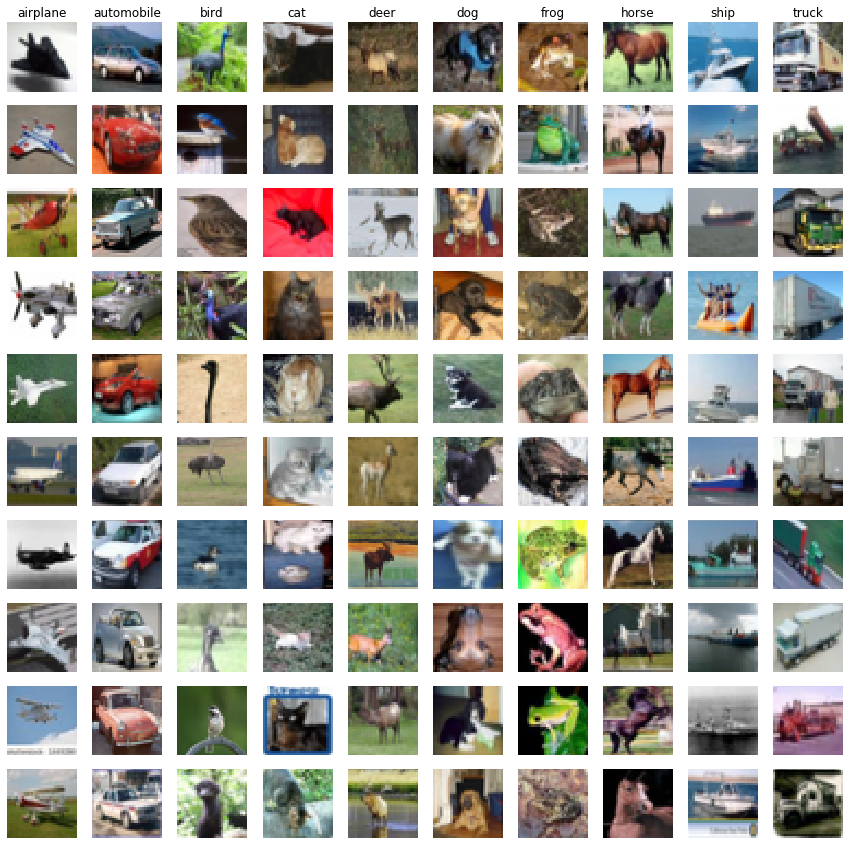

In [6]:
# Display 10 samples from each of the 10 classes in cifar-10 dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images_to_plot = None
for i in range(0, len(classes)):
    index = np.where(cy_train==i)[0]
    if i == 0:
        images_to_plot = cx_train[index[0:10],:,:]
    else:
        images_to_plot = np.vstack((images_to_plot, cx_train[index[0:10],:,:]))
images_to_plot = images_to_plot.reshape(10,10,32, 32, 3).transpose(1,0,2,3,4).reshape(100,32,32,3)
plot_colour_images(images_to_plot, nrows=10, ncols=10,thefigsize=(15,15), titles=classes)

In [9]:
# We start by creating a CNN model

# Convolutional layers with batch normalization and max pooling. Refer to Chollet's book for details on 
# pooling and also for padding and strides. For batch normalization refer to the paper in the references below.
model = models.Sequential()
filter_size = (3,3)
filters = 32
model.add(layers.Conv2D(filters, filter_size, strides=1, padding='same',activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization()) 
model.add(layers.Conv2D(filters, filter_size, strides=1, padding='same',activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

filters = 64
model.add(layers.Conv2D(filters, filter_size, strides=1, padding='same',activation='relu'))
model.add(BatchNormalization()) 
model.add(layers.Conv2D(filters, filter_size, strides=1, padding='same',activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

filters = 128
model.add(layers.Conv2D(filters, filter_size, strides=1, padding='same',activation='relu'))
model.add(BatchNormalization()) 
model.add(layers.Conv2D(filters, filter_size, strides=1, padding='same',activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [8]:
#classification layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

This creates a convolutional network similar to Figure 1. 

![Image](figures/cnn_arch.png?raw=true)

Figure 1: Architecture of a CNN — Source: https://www.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html

# We have already trained a model with the complete cifar-10 training data of 50,000 images and saved the model. You can skip the training of the model (which takes a while), in the following cells, to go directly to using the pre-trained model [here](#section1).

In [7]:
# to use softmax, we need to alter the class representations from integers to 'one-hot' 
cy_train_one_hot = to_categorical(cy_train)
cy_test_one_hot = to_categorical(cy_test)
cy_train_one_hot.shape, cy_train_one_hot.shape

((50000, 10), (50000, 10))

In [8]:
train_size = 1000

In [12]:
# Train the model
model.reset_states() 
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(cx_train[:train_size], cy_train_one_hot[:train_size,:], epochs=15, batch_size=64, shuffle=True)
model.save('cifar-10-model-complete-train')

ValueError: A target array with shape (1000, 10) was passed for an output of shape (None, 4, 4, 128) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

In [9]:
# Using pre-trained model with complete cifar-10 50,000 training images 
model = load_model('cifar-10-model-complete-pre-trained')

Let us now look more closely at the workings of convolutional layers.

Each convolutional layer applies a set of filters to the input image. These filters are typically of size 3x3 or 5x5 (for 2D image). Each filter is a neuron. So the 3x3 neuron has 9 weights. But typically images are 3D with a depth for color channels. In this case the neurons are also 3D. So for an image with 3 color channels or depth 3 each neuron will be 3x3x3 with 27 weights. This is probably more clear from Figure 2.

**Convolutional Layer**  |  **Neuron**
----------  |  ------
![Image](figures/depthcol.jpeg?raw=true) | ![Image](figures/neuron_model.jpeg?raw=true)

Figure 2: Left: An example input image in red (e.g. a 32x32x3 CIFAR-10 image), and an example set of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth in a convolutional layer, all looking at the same region in the input. Right: The neurons compute a dot product of their weights with the input (a 3x3x3 patch of the image) followed by a non-linearity(e.g. ReLu), but their connectivity is now restricted to be local spatially (a 3x3x3 patch of the image). Source - http://cs231n.github.io/convolutional-networks/

A convolution works by sliding filters of size 3 × 3 x 3 (if input has a depth of 3) over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of surrounding features of shape (filter_height, filter_width, input_depth). Each such 3D patch is then transformed via a tensor dot product with the filter or convolution kernel.

All of these vectors are then spatially reassembled into a 3D output map of shape (height, width, output_depth). Every spatial location in the output feature map corresponds to the same location in the input feature map (for example,the lower-right corner of the output contains information about the lower-right corner of the input). For instance, with 3× 3 windows, the vector output[i, j, :] comes from the 3D patch input[i-1:i+1, j-1:j+1, :]. The full process is detailed in Figure 3. 

![Image](figures/cnn_mapping.jpg?raw=true)

Figure 3: How convolution works - Source Francois Chollet's Deep Learning with Python

Figure 4 shows the convolution for a 2D input with a 3x3 filter.

![Image](figures/cnn_dot_prod.png?raw=true)

Figure 4: The filter slides over the input and performs its output on the new layer. — Source: https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2

Figure 5 shows a running demo of the convolution for a 3D input with 2 filters each 3x3x3. Since 3D volumes are hard to visualize, all the volumes (the input volume (in blue), the weight volumes (in red), the output volume (in green)) are visualized with each depth slice stacked in rows. The input volume is of size W1=5,H1=5,D1=3, and the convolution layer parameters are K=2,F=3x3x3,S=2,P=1. That is, we have two filters (K=2) of size 3×3x3 (F=3x3x3), and they are applied with a stride of 2. Therefore, the output volume size has spatial size (5 - 3 + 2)/2 + 1 = 3. Moreover, notice that a padding of P=1 is applied to the input volume, making the outer border of the input volume zero. The visualization below iterates over the output activations (green), and shows that each element is computed by elementwise multiplying the highlighted input (blue) with the filter (red), summing it up, and then offsetting the result by the bias.

![Image](figures/3d_conv.gif?raw=true)

Figure 5: Convolution Demo. Source: http://cs231n.github.io/convolutional-networks/



Now that we know how convolution works and what filters are let us look at what input images maximize the output of each filter or neuron in a convolutional layer in the model we learnt. To see what the conv layer is doing, a simple option is to apply the filter over raw input pixels to see what images contain the patterns that correspond to the pattern in the filter. 

The idea behind activation maximization of a filter is simple - generate an input image that maximizes the filter output activations. That is, we compute the gradient:

$$\frac{\delta input}{\delta ActivationMaximizationLoss}$$

where ActivationMaximizationLoss of the Nth filter is the loss function that maximizes the activation of the Nth filter. We use that estimate to update the input during gradient ascent. We have defined the loss to be the mean of the convolution output corresponding to the filter whose activation we want to maximize.

In [10]:
# Get the names of each layer in the model
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x14804ab70>,
 'batch_normalization_1': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x147fad550>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x147aa1e10>,
 'max_pooling2d_1': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x148065588>,
 'conv2d_3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x114575630>,
 'batch_normalization_2': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x114589390>,
 'conv2d_4': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1483685f8>,
 'max_pooling2d_2': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x1483e51d0>,
 'conv2d_5': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1483e52e8>,
 'batch_normalization_3': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x1483f3a58>,
 'conv2d_6': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x14845ef60>

In [11]:
# Utility function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= tf.reduce_mean(x)
    x /= (tf.math.reduce_std(x) + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((0, 1, 2))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [12]:
# Function to visualize the activate of given filter in the given layer
def visualize_activation(layer_name, filter_index):    
    input_img_data =  tf.convert_to_tensor((np.random.random((1, 32, 32, 3)) * 20 + 128.), dtype=tf.float32)
    step = 1
    
    for _ in range(150):
        #Track the inputs to the layers, output of each layer is the input to the next layer
        outputs = [input_img_data]
        
        with tf.GradientTape() as tape:
            # Watch inputs
            tape.watch(outputs)
            tape.watch(input_img_data)
            
            # Apply the input to each layer to get the outputs of each layer
            # until the layer specified
            for layer in model.layers:
                layer_output = layer(outputs[-1])
                if layer.name == layer_name:                  
                    if isinstance(layer, layers.Dense):
                        loss_value = K.mean(layer_output[:, filter_index])
                    else:  
                        loss_value = K.mean(layer_output[:, :, :, filter_index])
                    loss_value = K.mean(layer_output)
                    break
                outputs.append(layer(outputs[-1]))          

        grads = tape.gradient(loss_value, input_img_data)  
        
        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
        
        # some filters get stuck to 0, we can skip them
        if loss_value <= K.epsilon():
            return None, None
        # Add the gradients to the input image
        input_img_data += grads * step
    img = deprocess_image(input_img_data.numpy()[0])
    return img, loss_value

In [13]:
# We will maximize activation of all the filters in the last convolutional layer, as they learn more complex patterns. 
# But you can use the same procedure to visualize any filter in any layer.

# Filters that get stuck in 0 are skipped

layer_name = 'conv2d_6'
output_layer = layer_dict[layer_name]

# Get the number of filters in layer_name
num_filters = len(output_layer.get_weights()[1])
print('Layer ', layer_name, ' has ', num_filters, ' filters')

# Visualize activations of all the filters in the current layer
processed_filters = []
for i in range(0, num_filters):
    img, loss_value = visualize_activation(layer_name, i)
    if not img is None: 
        print('Processed filter ', i)
        processed_filters.append((img, loss_value))
print('Number of filters with non-zero loss are ', len(processed_filters))

Layer  conv2d_6  has  128  filters
Processed filter  0
Processed filter  1
Processed filter  2
Processed filter  3
Processed filter  4
Processed filter  5
Processed filter  6
Processed filter  7
Processed filter  8
Processed filter  9
Processed filter  10
Processed filter  11
Processed filter  12
Processed filter  13
Processed filter  14
Processed filter  15
Processed filter  16
Processed filter  17
Processed filter  18
Processed filter  19
Processed filter  20
Processed filter  21
Processed filter  22
Processed filter  23
Processed filter  24
Processed filter  25
Processed filter  26
Processed filter  27
Processed filter  28
Processed filter  29
Processed filter  30
Processed filter  31
Processed filter  32
Processed filter  33
Processed filter  34
Processed filter  35
Processed filter  36
Processed filter  37
Processed filter  38
Processed filter  39
Processed filter  40
Processed filter  41
Processed filter  42
Processed filter  43
Processed filter  44
Processed filter  45
Processed

In [14]:
model.layers

In [15]:
# We can also visualize the dense layer output. Here we visualize the last dense layer of the model for the class bird
layer_name = 'dense_2'

# Index for class bird
class_index = 3
img, loss_value = visualize_activation(layer_name, class_index)
processed_dense_filters = [(img, loss_value)]

In [16]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Function to create a stitched image of the individual images of the filters and save it to a file
def draw_filters(filters, model_name, output_dim=(32, 32), n=None):
    """Draw the best filters in a nxn grid.
    # Arguments
        filters: A List of generated images and their corresponding losses
                 for each processed filter.
        model_name: String specifying the name of the model
        n: dimension of the grid.
           If none, the largest possible square will be used
    """
    if n is None:
        n = int(np.floor(np.sqrt(len(filters))))

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top n*n filters.
    filters.sort(key=lambda x: x[1], reverse=True)
    filters = filters[:n * n]

    # build a black picture with enough space for
    # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
    MARGIN = 5
    width = n * output_dim[0] + (n - 1) * MARGIN
    height = n * output_dim[1] + (n - 1) * MARGIN
    stitched_filters = np.zeros((width, height, 3), dtype='uint8')

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, _ = filters[i * n + j]
            width_margin = (output_dim[0] + MARGIN) * i
            height_margin = (output_dim[1] + MARGIN) * j
            stitched_filters[
                width_margin: width_margin + output_dim[0],
                height_margin: height_margin + output_dim[1], :] = img

    print(stitched_filters.shape)

    # save the result to disk
    mpimg.imsave('{0:}_{1:}_{2:}x{2:}.png'.format(model_name, layer_name, n), stitched_filters)
    image_file_name ='{0:}_{1:}_{2:}x{2:}.png'.format(model_name, layer_name, n)
    return image_file_name

Populating the interactive namespace from numpy and matplotlib


(402, 402, 3)


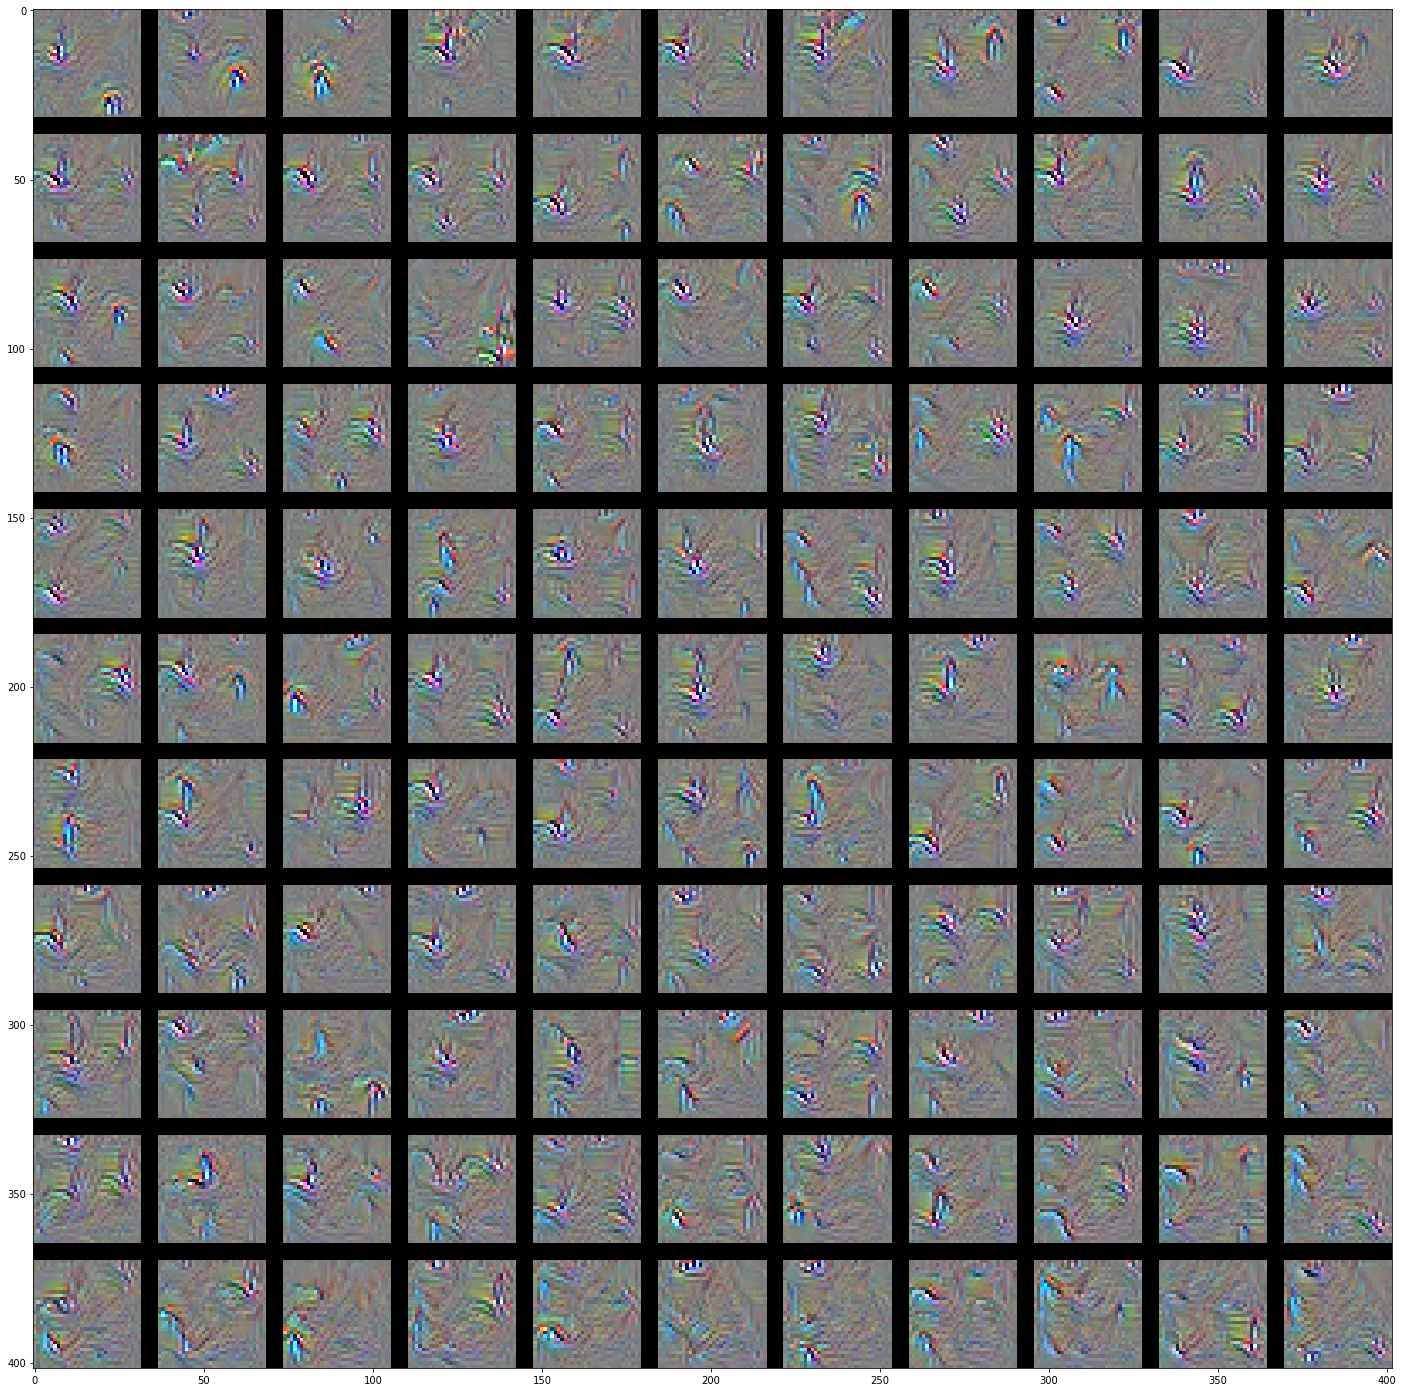

In [26]:
# Visualize the processed filters of the last convolutional layer. Here we visualize the top few filters with the 
# maximum activations and save the visualization as an image on disk
model_name = 'cifar-10'
result = draw_filters(processed_filters,  model_name, (32, 32))
img=mpimg.imread(result)
plt.rcParams['figure.figsize'] = (25,25)
imgplot = plt.imshow(img)
plt.show()

(32, 32, 3)


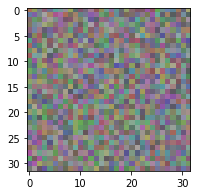

In [27]:
# Visualize the output of the dense layer for the class bird processed above. 
model_name = 'cifar-10-dense'
result = draw_filters(processed_dense_filters,  model_name, (32, 32))
img=mpimg.imread(result)
plt.rcParams['figure.figsize'] = (3,3)
imgplot = plt.imshow(img)
plt.show()

In [28]:
# This function visualizes the top 10 activated filters of each of the convolutional layer when an image of one of the
# classes of cifar-10 dataset is predicted using the trained model. This visualization gives an idea of how each layer
# sees the image
def visualize_filters_for_class(class_name):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Select a random image of the given class
    index = np.where(cy_test==classes.index(class_name))[0]
    sample = random.randint(0,len(index)-1)
    input_img = cx_test[index[sample],:,:]

    plt.rcParams['figure.figsize'] = (4,4)
    plt.imshow(input_img)

    input_img = input_img.reshape(1, 32, 32, 3).astype(float)

    #Predict the class of the selected image
    output_class = np.argmax(model.predict(input_img))

    # Get outputs of each layer
    layer_outs = []
    outputs = [tf.convert_to_tensor(input_img)]
    for layer in model.layers:
        layer_output = layer(outputs[-1])
        outputs.append(layer_output)
        layer_outs.append(layer_output)
        
    # Index corresponding to convolutional layers
    conv_layers = [0, 2, 4, 6, 8, 10]

    for layer in conv_layers:
        output_images = np.squeeze(layer_outs[layer], axis=0)
    
        filter_images = []
        num_filters = output_images.shape[2]
        for filter_index in range(0, num_filters):
            # Compute the activation of the filter
            loss_value = np.mean(output_images[:,:,filter_index])
            filter_images.append((output_images[:,:,filter_index], loss_value))

        # Sort filters in decreasing order of their activations
        filter_images.sort(key=lambda x: x[1], reverse=True)
        fig,ax = plt.subplots(1, 9, sharex=True, sharey=True, figsize=(18,18))
        ax = ax.flatten()
        i = 0
        # Visualize the top 10 most activated filters in the layer
        for img in filter_images[0:9]:
            image = img[0]
            #print(image.sum())

            ax[i].imshow(image) 
            ax[i].axis('off')    
            i += 1
    

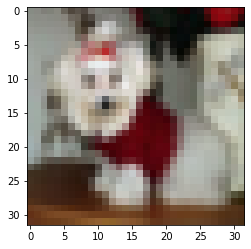

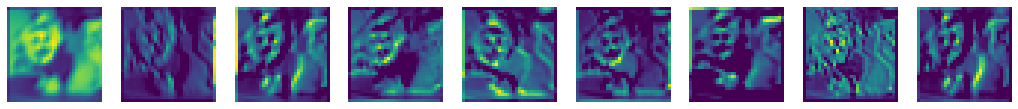

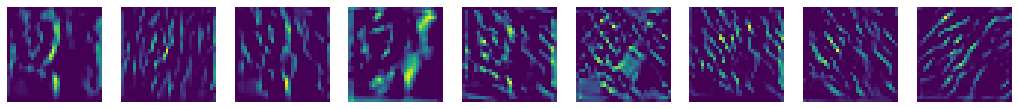

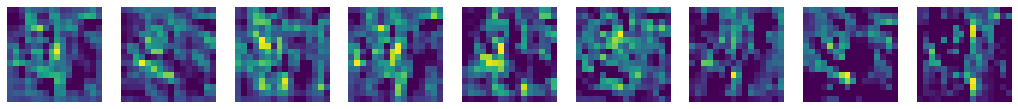

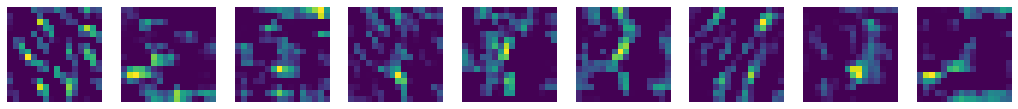

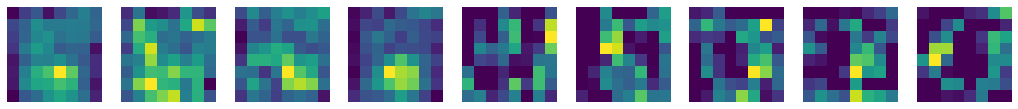

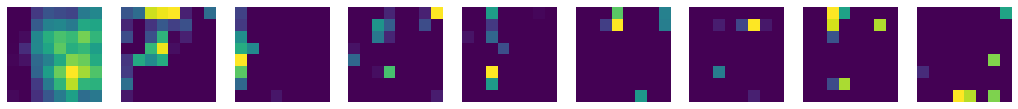

In [30]:
# Choose a class from the 10 classes 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 
#'ship', 'truck' and visualize the activations of all the layers of the model when this image is predicted.
# The output shows the top 10 activated filters for each of the 6 convolutional layers of the model
visualize_filters_for_class('dog')

# Additional references for visualizing activations of convolutional layers

* Following are nice blogs that describes how convolutional networks work.
    * [Convolutional Neural Networks (CNNs / ConvNets)](http://cs231n.github.io/convolutional-networks/)
    * [An intuitive guide to Convolutional Neural Networks](https://medium.freecodecamp.org/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050)
    * [A Beginner's Guide To Understanding Convolutional Neural Networks](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)
* Batach normalization in keras implements algorithm in [this](http://proceedings.mlr.press/v37/ioffe15.pdf) paper. 
* cifar-10 images are quite low resolution so the patterns seen are not as interesting. To see more interesting visualizations of activations see the following resources to generate images that maximize activations of filters in convolutional layers of a model trained on imagenet:
    * Install [keras-vis](https://github.com/raghakot/keras-vis) and look at the [vggnet example](https://github.com/raghakot/keras-vis/tree/master/examples/vggnet).
    * [How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) blog by Francois Chollet.
